# Training/Test split
- Create $N-1$ equidistant splits where $N$ is the number of covered years
- For each split normalize the distributions and compute the KL divergence between the training and test set
- Finally, compute the maximum KL divergence and plot both the histograms 

In [64]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [65]:
# Get the merged malware data
df = pd.read_csv("vt_reports/merge.csv")
df.head()

,sha256,first_submission_date,family
0,98f8e26e12b978102fa39c197f300ebe5fe535617737d5...,1630575593,tnega
1,7b2999ffadbc3b5b5c5e94145ca4e2f8de66ac1e3ddd52...,1629375559,quasar
2,e7569d494fe00be04ef6c9fcc5e54720c0df623b08e79d...,1362057319,pasta
3,1ed60c04f572b6acb9f64c31db55ef5c6b5465bd4da1eb...,1630624233,cjishu
4,4c4aaff20a57213d9a786e56ad22f1eaa94694a2f1042b...,1592186154,kingsoft


In [66]:
fsd = "first_submission_date"

In [67]:
# Convert the date to datetime
df_dt = df.copy()
df_dt[fsd] = df_dt[fsd].apply(lambda t: pd.to_datetime(t, unit='s'))

In [68]:
fsd = "first_submission_date"

# Min and maximum dates
date_min = df_dt[fsd].min()
date_max = df_dt[fsd].max()

# Create equidistant splits
date_splits = [pd.Timestamp(f"{date_min.year}-{date_min.month}-{date_min.day}") +
               pd.Timedelta(i * (date_max - date_min).days / (date_max.year - date_min.year), unit='D')
               for i in range(1, date_max.year - date_min.year)]
date_splits

[Timestamp('2007-05-18 00:00:00'),
 Timestamp('2008-05-13 00:00:00'),
 Timestamp('2009-05-09 00:00:00'),
 Timestamp('2010-05-05 00:00:00'),
 Timestamp('2011-05-01 00:00:00'),
 Timestamp('2012-04-26 00:00:00'),
 Timestamp('2013-04-22 00:00:00'),
 Timestamp('2014-04-18 00:00:00'),
 Timestamp('2015-04-14 00:00:00'),
 Timestamp('2016-04-09 00:00:00'),
 Timestamp('2017-04-05 00:00:00'),
 Timestamp('2018-04-01 00:00:00'),
 Timestamp('2019-03-28 00:00:00'),
 Timestamp('2020-03-23 00:00:00'),
 Timestamp('2021-03-19 00:00:00')]

In [104]:
def split_and_normalize(src_df: pd.DataFrame, split_condition: bool, split_label: str = ""):
    dst_df = src_df[split_condition]
    dst_df = dst_df.groupby(["family"]).size().reset_index(name='count')
    dst_df["perc"] = dst_df["count"] / dst_df["count"].sum()
    dst_df["split"] = split_label
    return dst_df


def kl_divergence(p, q):
    epsilon = 1e-7
    p = np.clip(p, epsilon, 1 - epsilon)
    q = np.clip(q, epsilon, 1 - epsilon)
    return np.sum(p * np.log(p / q))

In [105]:
# Compute the KL divergence for each possible split
df_split = df_dt.copy()
kl_divergences = []
for date_split in date_splits:
    # Split the dataset
    df_train = split_and_normalize(df_split, df_split[fsd] < date_split)
    df_test = split_and_normalize(df_split, df_split[fsd] >= date_split)
    kl_divergences.append(kl_divergence(df_train["perc"], df_test["perc"]))

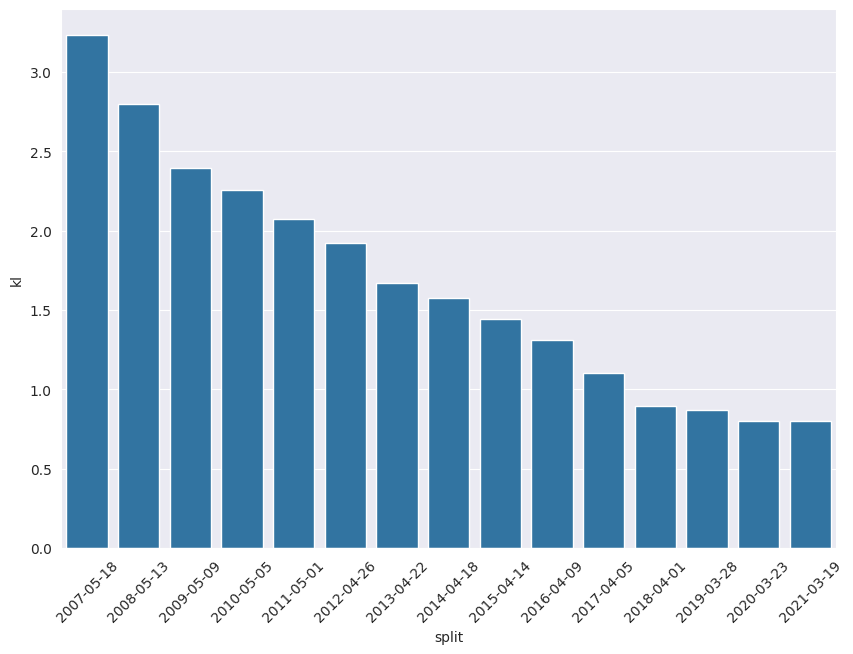

In [125]:
df_merge_kl = pd.DataFrame({"split": date_splits, "kl": kl_divergences})
plt.figure(figsize=(10, 7))
sns.barplot(data=df_merge_kl, x="split", y="kl")
plt.xticks(rotation=45)
plt.show()

Max KL divergence: 3.232605883830189, Best split: 2007-05-18 00:00:00


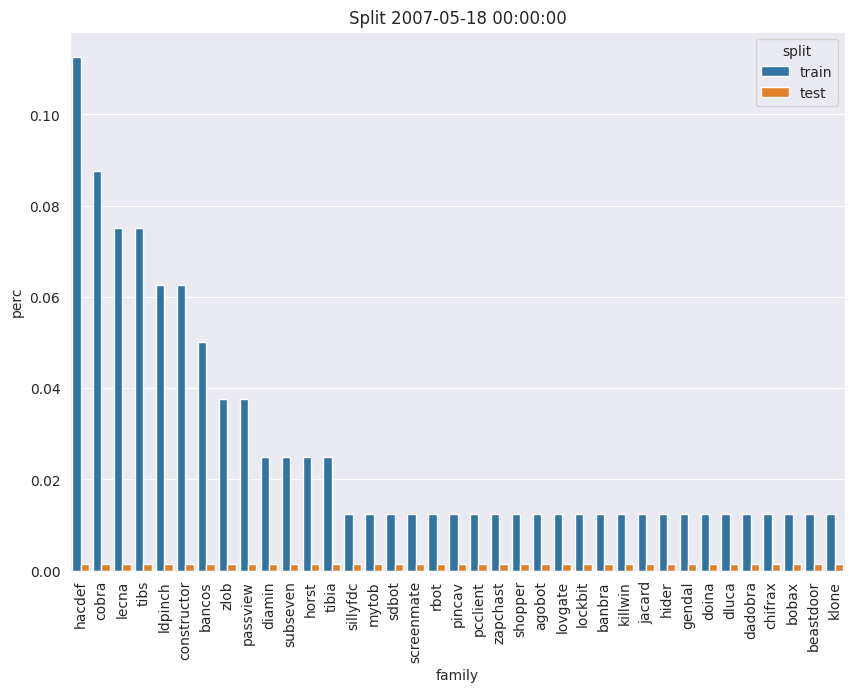

In [124]:
# Get the maximum KL divergence and plot the histogram
max_idx, max_kl = np.argmax(kl_divergences), np.max(kl_divergences)
best_split = date_splits[max_idx]

print(f"Max KL divergence: {max_kl}, Best split: {best_split}")

# Split the dataset
df_train = split_and_normalize(df_split, df_split[fsd] < best_split, "train")
df_test = split_and_normalize(df_split, df_split[fsd] >= best_split, "test")

df_merge_kl = pd.merge(left=df_train, right=df_test, on="family")
df_merge_kl["diff"] = abs(df_merge_kl["perc_x"] - df_merge_kl["perc_y"])

# Take the top 40 rows that maximizes the difference 
df_merge_kl = df_merge_kl.sort_values(by="diff", ascending=False).head(100)

data = lambda p, s: {"family": df_merge_kl["family"],
                     "perc": df_merge_kl[p],
                     "split": df_merge_kl[s]
                     }
df_train = pd.DataFrame(data("perc_x", "split_x"))
df_test = pd.DataFrame(data("perc_y", "split_y"))

df_merge = pd.concat([df_train, df_test])
plt.figure(figsize=(10, 7))
plt.title(f"Split {best_split}")
sns.barplot(data=df_merge, x="family", y="perc", hue="split")
plt.xticks(rotation=90)
plt.show()

In [116]:
# kl_contributions = []
# df_split = df_dt.copy()
# # Re-compute the KL divergence at the best split by iteratively deleting each family from the dataset,
# # in order to find the families that mostly contributed to the shift.
# for i in range(1, len(df_merge_kl["family"])):
#     # Split the dataset
#     df_split_f = df_split[~df_split["family"].isin(df_merge_kl["family"].head(i))]
# 
#     df_train = split_and_normalize(df_split_f, df_split_f[fsd] < best_split)
#     df_test = split_and_normalize(df_split_f, df_split_f[fsd] >= best_split)
# 
#     kl_contributions.append(max_kl - kl_divergence(df_train["perc"], df_test["perc"]))

In [ ]:
# df_kl_contributions = pd.DataFrame(
#     {
#         "Num excluded top families": range(1, len(df_merge_kl["family"])), 
#         "KL contribution": kl_contributions
#      }
# )
# df_kl_contributions_sorted = df_kl_contributions.sort_values(by="KL contribution", ascending=False)
# 
# plt.figure(figsize=(10, 7))
# plt.title(f"KL family contribution at split {best_split}")
# sns.barplot(data=df_kl_contributions.head(10), x="Num excluded top families", y="KL contribution")
# plt.xticks(rotation=90)
# plt.show()

In [ ]:
kl_contributions = []
df_split = df_dt.copy()
# Re-compute the KL divergence at the best split by iteratively deleting each family from the dataset,
# in order to find the families that mostly contributed to the shift.
for family in df["family"].unique():
    # Split the dataset
    df_split_f = df_split[df_split["family"] != family]

    df_train = split_and_normalize(df_split_f, df_split_f[fsd] < best_split)
    df_test = split_and_normalize(df_split_f, df_split_f[fsd] >= best_split)

    kl_contributions.append(max_kl - kl_divergence(df_train["perc"], df_test["perc"]))

In [ ]:
df_kl_contributions = pd.DataFrame({"family": df["family"].unique(), "KL contribution": kl_contributions})
df_kl_contributions_sorted = df_kl_contributions.sort_values(by="KL contribution", ascending=False)

plt.figure(figsize=(10, 7))
plt.title(f"KL family contribution at split {best_split}")
sns.barplot(data=df_kl_contributions_sorted.head(40), x="family", y="KL contribution")
plt.xticks(rotation=90)
plt.show()

In [122]:
df_merge_kl_1 = df_merge_kl

df_kl_contributions_sorted_f = df_merge_kl.sort_values(by="family").reset_index()
df_variances_f = pd.read_csv("variances.csv").sort_values(by="family").reset_index()
correlation = df_variances_f["variance"].corr(df_kl_contributions_sorted_f["diff"])
print(f"Variance-KL correlation: {correlation}")

Variance-KL correlation: -0.18753391562439425


In [126]:
unique_families = df["family"].unique()


def sum_kl(dff, date_split, ref_date, l):
    kl_divergences = []
    for family in unique_families:
        sub_df = dff[dff["family"] == family]
        # Create an array of day count for each day in the first half
        days_count = np.zeros(abs((date_split - ref_date).days) + 1)
        # From each date in the first half compute the offset relative to days_count
        off = [abs((day - ref_date).days) for day in sub_df[fsd]]
        #print(off)
        # Set each off cell with the respective count
        for index, value in zip(off, sub_df["count"]):
            days_count[index] = value

        count_sum = dff[dff["family"] == family]["count"].sum()
        kl_divergences.append(kl_divergence(days_count, np.full(len(days_count), 100 / l)))
    return kl_divergences
    #return sum(kl_divergences)


In [127]:
# Compute the KL divergence for each possible split
df_split = df_dt.copy()
kl_divergences = []

date_min_1 = pd.Timestamp(f"{date_min.year}-{date_min.month}-{date_min.day}")
date_max_1 = pd.Timestamp(f"{date_max.year}-{date_max.month}-{date_max.day}")

length_in_days = (date_max_1 - date_min_1).days

df_split[fsd] = df_split[fsd].apply(lambda d: pd.Timestamp(d.strftime('%Y-%m-%d')))
df_split_gb = pd.DataFrame(df_split.groupby(["family", fsd]).size().reset_index(name='count'))

kl_sum_diff = []
for date_split in date_splits:
    df_train = df_split_gb[df_split_gb[fsd] < date_split]
    df_test = df_split_gb[df_split_gb[fsd] >= date_split]

    k1 = sum_kl(df_train, date_split, date_min_1, length_in_days)
    k2 = sum_kl(df_test, date_split, date_max_1, length_in_days)

    kl_sum_diff.append(sum(
        [abs(k1[i] - k2[i]) for i in range(len(k1))]
    ))

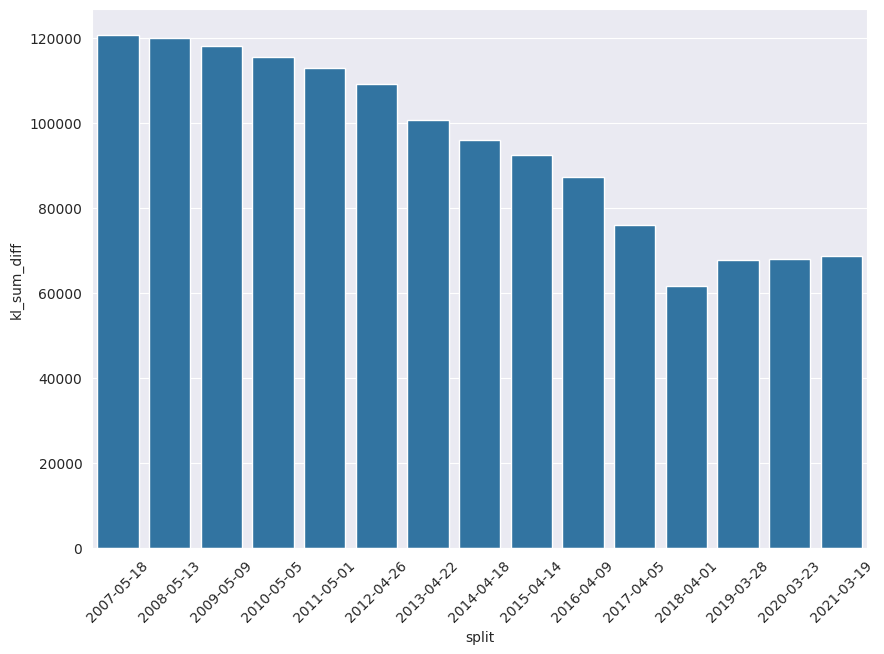

In [128]:
df_merge_kl_sum_diff = pd.DataFrame({"split": date_splits, "kl_sum_diff": kl_sum_diff})
plt.figure(figsize=(10, 7))
sns.barplot(data=df_merge_kl_sum_diff, x="split", y="kl_sum_diff")
plt.xticks(rotation=45)
plt.show()

In [79]:
df_family_timespan = df_dt.groupby(by="family").agg({
    "first_submission_date": ["min", "max"],
}).reset_index()
df_family_timespan.head()

family first_submission_date                    
                               min                 max
0    4shared   2015-05-11 19:37:15 2021-12-26 21:33:12
1      aauto   2016-07-28 01:09:12 2021-12-24 11:12:10
2   adaebook   2007-08-08 11:47:55 2021-12-27 10:44:21
3  addlyrics   2013-01-09 18:34:27 2022-02-16 15:45:48
4  adgazelle   2014-03-05 14:28:12 2022-03-08 20:20:11

In [131]:
date_range = pd.date_range(start=date_min_1, end=date_max_1, freq='D')

df_1 = df_family_timespan.copy()
df_1[("first_submission_date", "max")] = df_family_timespan[("first_submission_date", "max")].apply(
    lambda t: f"{t.year}-{t.month}-{t.day}"
)
df_1[("first_submission_date", "min")] = df_family_timespan[("first_submission_date", "min")].apply(
    lambda t: f"{t.year}-{t.month}-{t.day}"
)

date_range_day = [f"{t.year}-{t.month}-{t.day}" for t in date_range]

count_t_dis = []
count_t_app = []
for t in date_range:
    print(df_1[("first_submission_date", "min")])

    count_t_dis.append(len(df_1[df_1[("first_submission_date", "max")] == t]))
    count_t_app.append(len(df_1[df_1[("first_submission_date", "min")] == t]))


0       2015-5-11
1       2016-7-28
2        2007-8-8
3        2013-1-9
4        2014-3-5
          ...    
665    2011-12-24
666     2018-2-12
667     2013-1-30
668     2013-3-12
669     2009-2-12
Name: (first_submission_date, min), Length: 670, dtype: object
0       2015-5-11
1       2016-7-28
2        2007-8-8
3        2013-1-9
4        2014-3-5
          ...    
665    2011-12-24
666     2018-2-12
667     2013-1-30
668     2013-3-12
669     2009-2-12
Name: (first_submission_date, min), Length: 670, dtype: object
0       2015-5-11
1       2016-7-28
2        2007-8-8
3        2013-1-9
4        2014-3-5
          ...    
665    2011-12-24
666     2018-2-12
667     2013-1-30
668     2013-3-12
669     2009-2-12
Name: (first_submission_date, min), Length: 670, dtype: object
0       2015-5-11
1       2016-7-28
2        2007-8-8
3        2013-1-9
4        2014-3-5
          ...    
665    2011-12-24
666     2018-2-12
667     2013-1-30
668     2013-3-12
669     2009-2-12
Name: (first_submis

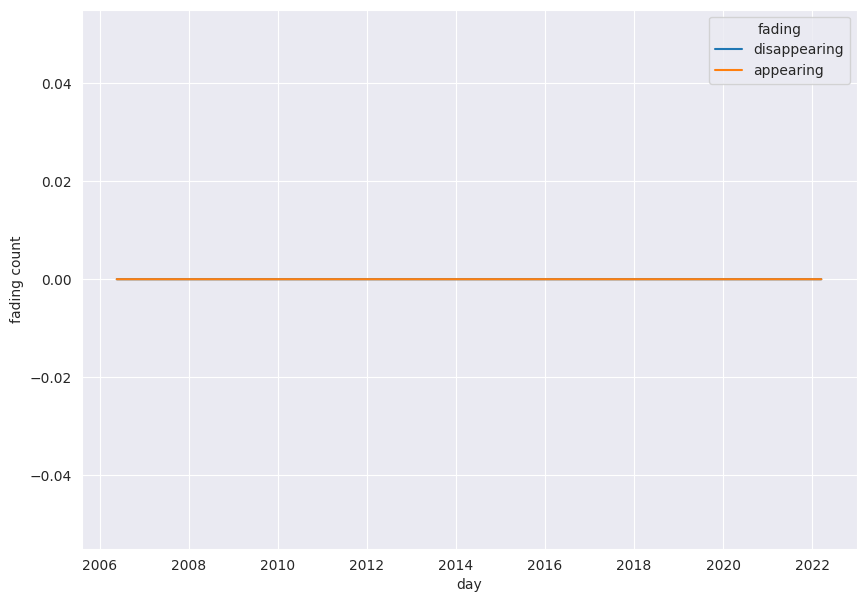

In [130]:
date_range_day_t = [pd.Timestamp(t) for t in date_range_day]

df_dis = pd.DataFrame({"day": date_range_day_t, "fading count": count_t_dis})
df_dis["fading"] = "disappearing"

df_app = pd.DataFrame({"day": date_range_day_t, "fading count": count_t_app})
df_app["fading"] = "appearing"

df_fading = pd.concat([df_dis, df_app])

plt.figure(figsize=(10, 7))
sns.lineplot(data=df_fading, x="day", y="fading count", hue="fading")
plt.show()